<a href="https://colab.research.google.com/github/flyswot/gym/blob/master/flyswot_gym.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# flyswot-gym 🦾

This notebook moves through the steps involved in training/updating a flyswot model. 

> This notebook assumes you have already updated the flysheet `dataset` (see the [flyswot-gym](https://github.com/davanstrien/flyswot-gym) repository for guidance on doing this.). 

The notebook goes through the following steps:
- downloading the training data
- preparing the dataset for training the model
- training the model 
- evaluating the model in various ways
- making a decision about whether to save the model 
- uploading the model to the 🤗 hub

**Note: this notebook is a WIP, things might change or not work properly**

In [1]:
#@title Setup git and git-lfs
!apt install git-lfs && git init && git lfs install 
!git config --global credential.helper store

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.3.4-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Initialized empty Git repository in /content/.git/
Updated git hooks.
Git LFS initialized.


In [2]:
#@title Install flyswot-gym
!pip install git+https://github.com/flyswot/gym.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/flyswot/gym.git to /tmp/pip-req-build-8icelsxq
  Running command git clone -q https://github.com/flyswot/gym.git /tmp/pip-req-build-8icelsxq
     |████████████████████████████████| 451 kB 2.1 MB/s 
     |████████████████████████████████| 549 kB 1.4 MB/s 
     |████████████████████████████████| 237 kB 3.1 MB/s 
     |████████████████████████████████| 5.8 MB 525 kB/s 
     |████████████████████████████████| 72 kB 1.2 MB/s 
     |████████████████████████████████| 2.1 MB 10.2 MB/s 
     |████████████████████████████████| 212 kB 10.7 MB/s 
     |████████████████████████████████| 182 kB 15.3 MB/s 
     |████████████████████████████████| 132 kB 11.4 MB/s 
     |████████████████████████████████| 127 kB 15.1 MB/s 
     |████████████████████████████████| 10.7 MB 20.3 MB/s 
     |████████████████████████████████| 10.6 MB 23.7 MB/s 
     |████████████████████████████████|

## Restart kernel

The following cell will force colab to restart. This will cause an error to appear but you can safely run this and run the next cell down.

In [4]:
# from condacolab
print("🔁 Restarting kernel...")
get_ipython().kernel.do_shutdown(True)

🔁 Restarting kernel...


{'status': 'ok', 'restart': True}

Run from here after Colab has restarted!

In [1]:
from huggingface_hub import notebook_login
from huggingface_hub import hf_api
import torch

### Check for we have a GPU available

Google Colab gives us the option of running our code on a GPU. This is important for speeding up our training process. If the below cell fails check you have a GPU enabled. Sometimes you may have to wait a little while for Colab to have GPUs available. 


In [2]:
assert torch.cuda.is_available()

## Define some training options

We define some different training options. The first `model_checkpoint` refers to the model we *start* our training from. This is setup to use an existing flyswot model by default. If you have made massive changes to the data, or are training on a new task you may want to change this model to another model. Any `image-classification` [model](https://huggingface.co/models?pipeline_tag=image-classification) *should* work. A safe bet is to start with `facebook/convnext-tiny-224`. To use any of these models pass in the Hub id. You can get this from the top of a model page on the hub by clicking on the double square icon


The other options are `training_dataset` this should point to a dataset you've uploaded using `hugit`. 

The number of epochs defines how long you will train your model for. If you are fine tuning an existing flyswot model you won't need to change this much but if you are training something new you will want to increase this value. 

In [3]:
#@title Define training options
model_checkpoint = 'google/vit-base-patch16-224' #@param ["flyswot/convnext-tiny-224_flyswot", "davanstrien/deit_flyswot"] {allow-input: true}
training_dataset = "flyswot/test" #@param ["flyswot/flysheet_data"] {allow-input: true}
number_of_epochs = 25 #@param {type:"slider", min:5, max:100, step:1}

## Tips

This notebook attempts to make the process of training/updating a model easier. This is partially done by creating some functions that do a bunch of different steps for you. In this notebook we often just call these functions. This means we see a couple of lines of code instead of a whole bunch of code. However, nothing is supposed to be hidden or magical because of this. If you want to know what a particular function is doing you can use a handy feature inside notebook to see what some code does. 
Placing `??` will show the source code for a function, for example, we can take a look at what `prep_data` is doing:

In [4]:
from gym.core import prep_data

In [8]:
??prep_data

This means firstly that you can see more clearly what is happening but also if you feel like it's doing the wrong thing you can copy the code an update how that step of the notebook happens. 

# Login to the 🤗 hub 

Since we're using private datasets and we want to have the option of pushing our models to the 🤗 hub we ned to ensure we are logged in.

In [5]:
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


## Setup training data

This part of the notebook setups the training data for our model. The way in which the data is processed changes depending on our model which is why we need to pass in `model_checkpoint`. 

In [6]:
from gym.core import prep_data
from datasets import load_dataset

In [7]:
clone_url = f"https://huggingface.co/datasets/{training_dataset}"

In [8]:
!git lfs install
!git clone {clone_url}

Updated git hooks.
Git LFS initialized.
Cloning into 'test'...
remote: Enumerating objects: 1014, done.
remote: Counting objects: 100% (1014/1014), done.
remote: Compressing objects: 100% (1011/1011), done.
remote: Total 1014 (delta 2), reused 1004 (delta 0), pack-reused 0
Receiving objects: 100% (1014/1014), 144.56 KiB | 2.41 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Filtering content: 100% (994/994), 3.41 GiB | 87.14 MiB/s, done.


In [9]:
dataset = load_dataset("imagefolder", data_dir=training_dataset.split("/")[-1], split='train')

Resolving data files:   0%|          | 0/994 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-065ecde4afb9274d/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


In [10]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 994
})

In [11]:
flyswot_data = prep_data(dataset, model_checkpoint=model_checkpoint)

Preparing dataset...

dropping duplicates...

  0%|          | 0/994 [00:00<?, ?it/s]

creating train, valid, test splits...

train has 795 examples

valid has 179 examples

test has 20 examples

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

In [12]:
flyswot_data

FlyswotData(train_ds=Dataset({
    features: ['image', 'label'],
    num_rows: 795
}), valid_ds=Dataset({
    features: ['image', 'label'],
    num_rows: 179
}), test_ds=Dataset({
    features: ['image', 'label'],
    num_rows: 20
}), id2label={0: 'CONTAINER', 1: 'CONTROL SHOT', 2: 'COVER', 3: 'EDGE + SPINE', 4: 'FLYSHEET', 5: 'OTHER', 6: 'PAGE + FOLIO', 7: 'SCROLL'}, label2id={'CONTAINER': 0, 'CONTROL SHOT': 1, 'COVER': 2, 'EDGE + SPINE': 3, 'FLYSHEET': 4, 'OTHER': 5, 'PAGE + FOLIO': 6, 'SCROLL': 7})

In [13]:
assert flyswot_data, "make sure you have loaded data sucessfully"

## Model training 
We now have our data ready, next we train a model. By default this will use the paramters we chose earlier but we can switch this around if needed.

In [14]:
from gym import core

In [ ]:
trainer = core.train_model(flyswot_data,
                           model_checkpoint, 
                           num_epochs=number_of_epochs)

Dataset({
    features: ['image', 'label'],
    num_rows: 795
})

Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using cuda_amp half precision backend
***** Running training *****
  Num examples = 795
  Num Epochs = 25
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 4975
  Number of trainable parameters = 85804808


***** Running Evaluation *****
  Num examples = 179
  Batch size = 4


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to output_dir/checkpoint-199
Configuration saved in output_dir/checkpoint-199/config.json
Model weights saved in output_dir/checkpoint-199/pytorch_model.bin
Image processor saved in output_dir/checkpoint-199/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 179
  Batch size = 4
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to output_dir/checkpoint-398
Configuration saved in ou

# Inspecting model results

This section is a WIP!

We have a model. Now we want to know if it's any good. There are various ways in which we can explore this. First we can use the `trainer.predict` method to run our model against some test data.

In [18]:
outputs = trainer.predict(flyswot_data.test_ds)

***** Running Prediction *****
  Num examples = 20
  Batch size = 4


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


This output variable includes metrics for how our model performs on our test data.

In [19]:
outputs.metrics

{'test_loss': 0.6540695428848267,
 'test_precision': 0.8010204081632653,
 'test_recall': 0.761904761904762,
 'test_f1': 0.7543171114599686,
 'test_accuracy': 0.85,
 'test_runtime': 8.7512,
 'test_samples_per_second': 2.285,
 'test_steps_per_second': 0.571}

In [20]:
import pandas as pd

In [21]:
pd.DataFrame.from_dict(outputs.metrics,orient='index',columns=['score'])

score
test_loss                0.654070
test_precision           0.801020
test_recall              0.761905
test_f1                  0.754317
test_accuracy            0.850000
test_runtime             8.751200
test_samples_per_second  2.285000
test_steps_per_second    0.571000

In [25]:
# from sklearn.metrics import classification_report
# y_true = outputs.label_ids
# y_pred = outputs.predictions.argmax(1)
# print(classification_report(y_true, y_pred, target_names=flyswot_data.train_ds.features['label'].names))

In [26]:
from gym.core import plot_confusion_matrix

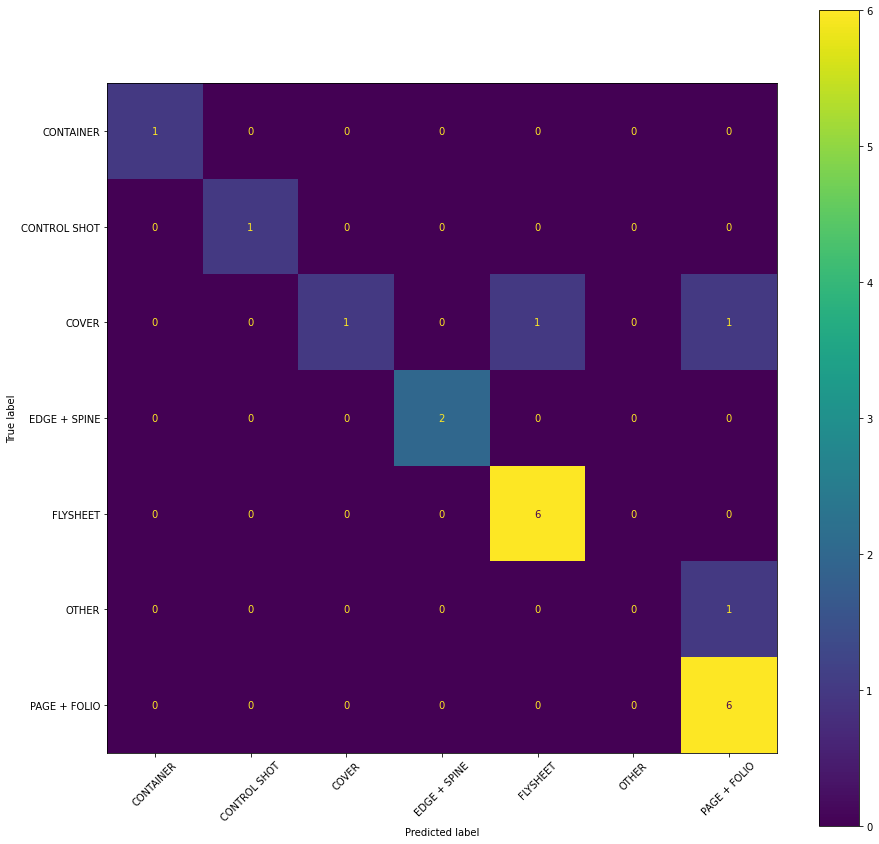

In [27]:
plot_confusion_matrix(outputs,trainer=trainer)

In [28]:
from gym.core import create_test_results_df

In [29]:
report_df = create_test_results_df(outputs,trainer, important_label='FLYSHEET', print_results=True,return_df=True)

misclasified:

y_true        y_pred    y_prob
12  OTHER  PAGE + FOLIO  0.507812
13  COVER  PAGE + FOLIO  0.267090
16  COVER      FLYSHEET  0.351807

Number of wrong predictions of FLYSHEET label: 1

Percentage of wrong predictions of FLYSHEET label: 5.0

In [30]:
mistakes_df = report_df[report_df.y_true != report_df.y_pred]

In [31]:
mistakes_df['y_prob'].max()

0.508

In [32]:
from gym.core import create_mistakes_image_navigator

Column
    [0] DiscreteSlider(formatter='%d', options=[0, 1, 2], value=0)
    [1] ParamFunction(function)
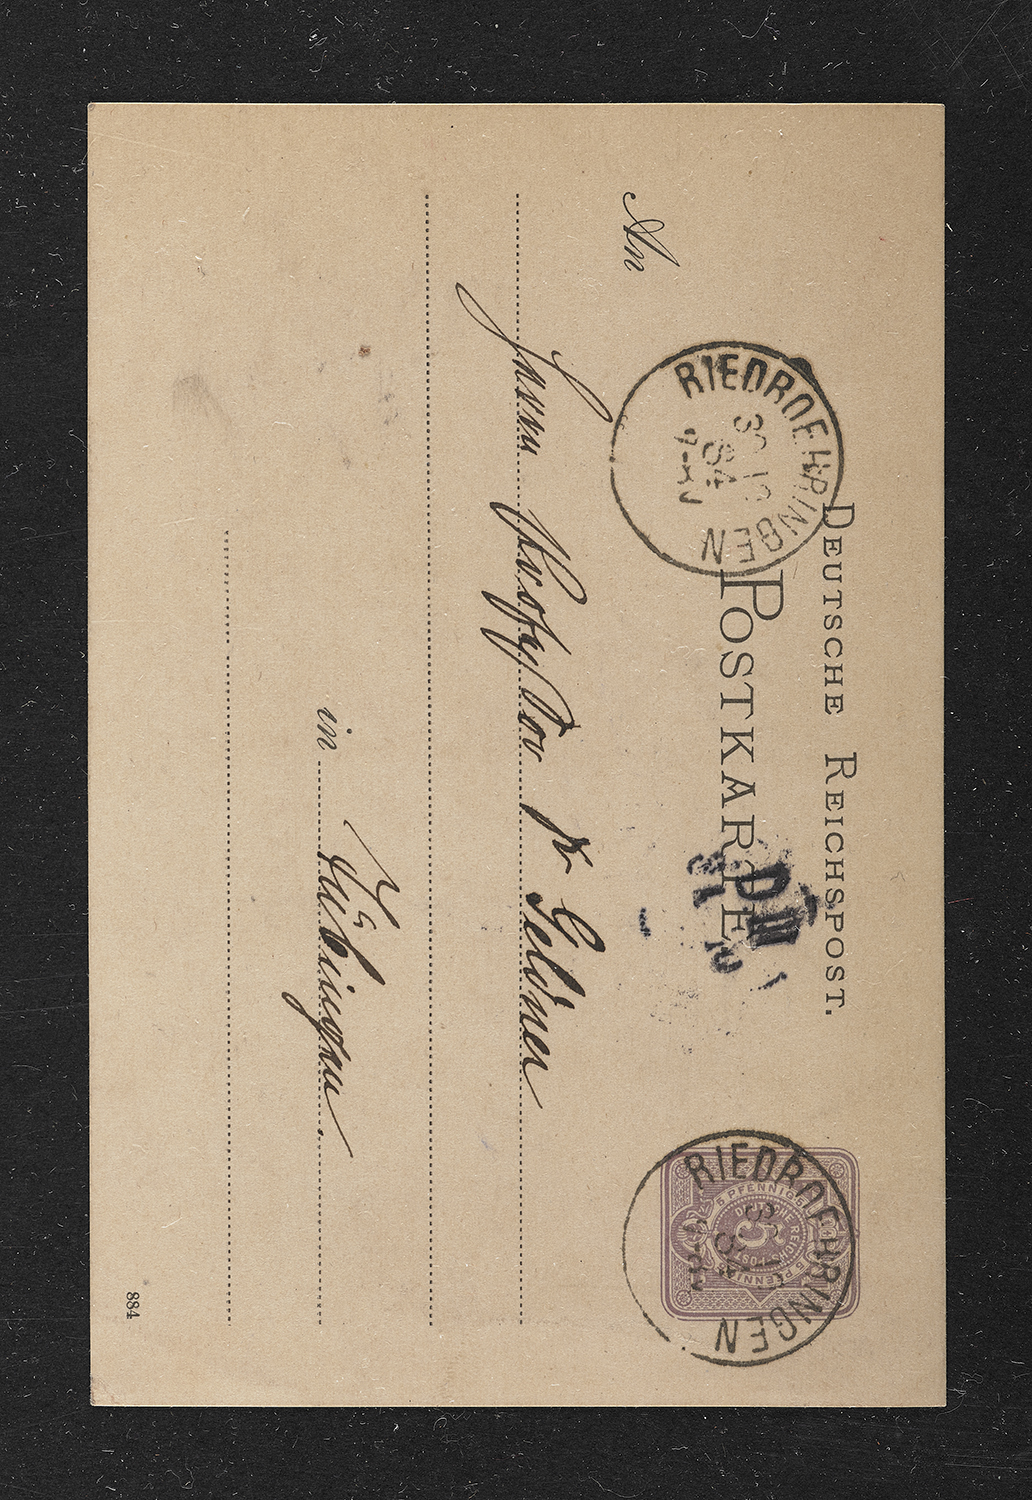

In [33]:
create_mistakes_image_navigator(report_df, flyswot_data, trainer)

## Push model to the hub? 

Once we have explored some of the model behaviour above we *should* have a better sense of whether it's a good model for our particular use case. 

To push a model to the hub, you can run the following cells. You should update the value of `model_hub_id` to reflect what you want the model ID on the Hugging Face hub to be. 

In [49]:
from transformers import Trainer, AutoModelForImageClassification

In [50]:
model_hub_id = "flyswot/december2022"

In [47]:
trainer.model.push_to_hub(model_hub_id)

Configuration saved in /tmp/tmpaxlb_n17/config.json
Model weights saved in /tmp/tmpaxlb_n17/pytorch_model.bin
Uploading the following files to flyswot/december2022: config.json,pytorch_model.bin


CommitInfo(commit_url='https://huggingface.co/flyswot/december2022/commit/fbd844f98b495a480516c839124f3412862ee81f', commit_message='Upload ViTForImageClassification', commit_description='', oid='fbd844f98b495a480516c839124f3412862ee81f', pr_url=None, pr_revision=None, pr_num=None)

In [48]:
trainer.tokenizer.push_to_hub(model_hub_id)

Image processor saved in /tmp/tmpg0j1e_08/preprocessor_config.json
Uploading the following files to flyswot/december2022: preprocessor_config.json


CommitInfo(commit_url='https://huggingface.co/flyswot/december2022/commit/3c18181159c63806031cfb9cf3ba71d84779fa1f', commit_message='Upload processor', commit_description='', oid='3c18181159c63806031cfb9cf3ba71d84779fa1f', pr_url=None, pr_revision=None, pr_num=None)

## TODOs
- generate a model card automagically based on some of the metric results already included 

